<p style="font-size:20px;">Simulator: QiskitAer, FakeTorino, ideal device noise simulator (no shot noise). H2 in minimal basis (STO-3G), JW mapping, 1-layered tUPS. With zero-parameters for training set, number of parameters is 3. Fitting methods: Square regression with a linear ansatz, add-and-subtract.</p>

In [1]:
import pyscf
import slowquant.SlowQuant as sq
from qiskit_nature.second_q.mappers import JordanWignerMapper
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.wavefunction import WaveFunction
#from slowquant.qiskit_interface.linear_response.projected import quantumLR

from qiskit_ibm_runtime.fake_provider import FakeTorino

from qiskit.primitives import Estimator

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import SamplerV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 0.735 0.0 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 1}, ISA = True)

#Remember to change the wavefunction to the correct molecule

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (2, 2),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
)

WF.run_vqe_2step("RotoSolve")

#no noise
nonclif_ground_state_energy = WF.energy_elec
print("Non-Clifford Ground state energy:", nonclif_ground_state_energy)

#device noise
# Update the primitive with simulated noise
backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)    
# Calculate the ground state energy using the noisy simulator
noisy_nonclif_ground_state_energy = WF.energy_elec
print("Noisy Non-Clifford Ground state energy:",noisy_nonclif_ground_state_energy)

converged SCF energy = -1.116998996754
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
Full optimization
Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------Ansatz optimization
--------Iteration # | Iteration time [s] | Electronic energy [Hartree]


/tmp/ipykernel_721597/317835389.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


--------     1      |         3.21       |     -1.8572750302023797    
Non-Clifford Ground state energy: -1.8572750302023793
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [103, 93, 102, 104]
 Non-local gates:     36
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cz', 'id', 'sx', 'measure', 'x', 'reset']>)

Noisy Non-Clifford Ground state energy: -1.732580263299815


In [3]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 0.735 0.0 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

primitive = Estimator()
mapper = JordanWignerMapper()
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 1}, ISA = True)

#Remember to change the wavefunction to the correct molecule

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (2, 2),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
)
print(WF.ansatz_parameters)

clifford_ground_state_energy = WF.energy_elec
print('Clifford ground state energy:', clifford_ground_state_energy)

backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)   
noisy_clifford_ground_state_energy = WF.energy_elec
print("Noisy clifford ground state energy:", noisy_clifford_ground_state_energy)


converged SCF energy = -1.116998996754


Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0]
Clifford ground state energy: -1.836967991202983


/tmp/ipykernel_721597/73752188.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [103, 93, 102, 104]
 Non-local gates:     36
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cz', 'id', 'sx', 'measure', 'x', 'reset']>)

Noisy clifford ground state energy: -1.7237245426616212


In [4]:
AS_prediction = noisy_nonclif_ground_state_energy + clifford_ground_state_energy - noisy_clifford_ground_state_energy
print('AS prediction:', AS_prediction)

AS prediction: -1.8458237118411769


In [5]:
#square regression with a linear ansatz
def cost_function(a, X_exact, X_noisy):
    a1, a2 = a  # 将参数 a 拆分为 a1 和 a2
    # 计算代价函数 C 的值
    C = (X_exact - (a1 * X_noisy + a2))**2
    return C
X_exact = np.array(clifford_ground_state_energy)
X_noisy = np.array(noisy_clifford_ground_state_energy)
# 初始猜测值 a1 和 a2
initial_guess = [1, 0]
# 最小化代价函数
result = minimize(cost_function, initial_guess, args=(X_exact, X_noisy))
# 得到最优的 a1 和 a2
a1_optimal, a2_optimal = result.x
print(f"最优的 a1 值: {a1_optimal}")
print(f"最优的 a2 值: {a2_optimal}")
y_pred_linear = a1_optimal*noisy_nonclif_ground_state_energy + a2_optimal
print('result of square regression:', y_pred_linear)

最优的 a1 值: 1.0491537074379318
最优的 a2 值: -0.028515992540745678
result of square regression: -1.8462589992155347


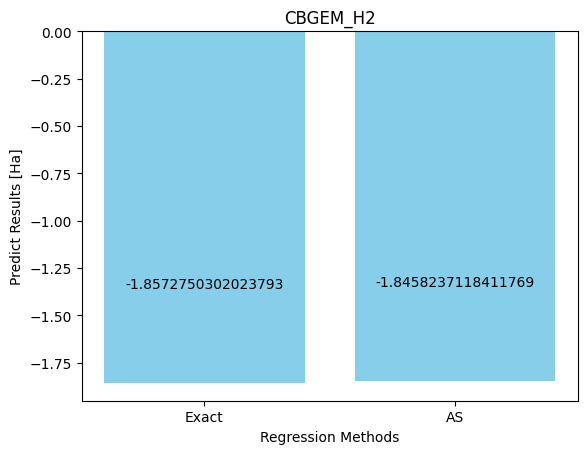

In [8]:
# 数据
categories = ['Exact', 'AS']
values = [nonclif_ground_state_energy, AS_prediction]

# 绘制柱状图
plt.bar(categories, values, color='skyblue')

# 添加标题和标签
plt.title('CBGEM_H2')
plt.xlabel('Regression Methods')
plt.ylabel('Predict Results [Ha]')

# 在每个柱子上标注数值
for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)

# 显示图表
plt.show()